In [1]:
# The code was removed by Watson Studio for sharing.

<h1>Choosing the safest place to live</h1>
<hr>
<h2>Choose the neighborhoods in NYC to live in the time of Corona</h2>

Research if there is a link between the number of restaurants, clubs and stadions with the COVID cases

Import the required libraries

In [2]:
# @hidden
CLIENT_ID = '4RADAMJCJOLS3XN055N1MQU5I3Y21F4HVKNVZSY1GJMSZTYF' # your Foursquare ID
CLIENT_SECRET = 'JZJVL4QLIBI22EXYRFOPAWJIZC0K1CLIAEB4FDQKC5VMKMEC' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Foursquare credentials hidden')

Foursquare credentials hidden


In [3]:
# @hidden
!pip install geopy folium
!pip install lxml html5lib beautifulsoup4
!pip install geocoder geopandas
!pip install geolocator
print('only installations')

     |████████████████████████████████| 102kB 8.5MB/s ta 0:00:011
     |████████████████████████████████| 102kB 7.8MB/s ta 0:00:011
     |████████████████████████████████| 931kB 15.4MB/s eta 0:00:01
     |████████████████████████████████| 1.8MB 35.3MB/s eta 0:00:01
     |████████████████████████████████| 14.7MB 32.6MB/s eta 0:00:01
     |████████████████████████████████| 10.9MB 33.4MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/fd/0f/35/478bc0f7f5c5acf6e5345db12383a79daeb524d75691691e15
Successfully built geolocator
only installations


In [4]:
import pandas as pd
import numpy as np
import requests # library to handle requests
import random # library for random number generation
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import folium # plotting library
import json # library to handle JSON files
print('Libraries imported.')

Libraries imported.


Import NY data from json

Import COVID cases
Drop postal code, as we will only use the neighborhood
Group data and sum COVID cases

In [5]:
dfcovid = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/master/data-by-modzcta.csv')

Prepare a drawing of COVID death daa

In [6]:
# download New York geojson file
#!wget --quiet https://github.com/fedhere/PUI2015_EC/blob/master/mam1612_EC/nyc-zip-code-tabulation-areas-polygons.geojson -O nyc.json
#nyc_geo = r'nyc.json' # geojson file
url = 'https://data.beta.nyc/dataset/3bf5fb73-edb5-4b05-bb29-7c95f4a727fc/resource/5fb3bac2-191f-4b90-a982-e6ece0e96a42/download'
nyc_tabulation = f'{url}/nyu-2451-34509-geojson.json'

nyc_geo = json.loads(requests.get(nyc_tabulation).text)


{'type': 'FeatureCollection', 'totalFeatures': 214, 'features': [{'type': 'Feature', 'id': 'nyu_2451_34509.1', 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[-74.00368399999996, 40.748354999999826], [-74.00652899999999, 40.749552999999814], [-74.00702299999996, 40.748889999999825], [-74.00862099999998, 40.749522999999826], [-74.00848699999997, 40.75035699999981], [-74.00794499999998, 40.75175999999982], [-74.00771299999997, 40.75244399999981], [-74.00744899999998, 40.75316499999982], [-74.00721799999998, 40.75387299999982], [-74.00681499999999, 40.75452199999982], [-74.00573299999999, 40.75596999999983], [-74.00543699999999, 40.75636399999982], [-74.00492699999998, 40.75702299999983], [-74.00294199999998, 40.75973099999982], [-74.00006699999999, 40.75840299999983], [-74.00013799999996, 40.7583069999998], [-74.00058399999999, 40.75769299999981], [-74.001055, 40.75706699999982], [-74.0015, 40.756451999999825], [-74.00081799999998, 40.75616199999982], [-74.000013, 40.756615999999

In [7]:
dfcovid['zcta'] = dfcovid['MODIFIED_ZCTA'].astype(str)
dfcovid.dtypes

MODIFIED_ZCTA          int64
NEIGHBORHOOD_NAME     object
BOROUGH_GROUP         object
COVID_CASE_COUNT       int64
COVID_CASE_RATE      float64
POP_DENOMINATOR      float64
COVID_DEATH_COUNT      int64
COVID_DEATH_RATE     float64
PERCENT_POSITIVE     float64
zcta                  object
dtype: object

In [8]:
from branca.colormap import linear

colormap = linear.YlGn_09.scale(
    dfcovid['COVID_DEATH_RATE'].min(),
    dfcovid['COVID_DEATH_RATE'].max())

coviddeath_dict = dfcovid.set_index('MODIFIED_ZCTA')['COVID_DEATH_COUNT']


In [9]:
dfcovid.head()

MODIFIED_ZCTA                        NEIGHBORHOOD_NAME BOROUGH_GROUP  \
0          10001               Chelsea/NoMad/West Chelsea     Manhattan   
1          10002                Chinatown/Lower East Side     Manhattan   
2          10003  East Village/Gramercy/Greenwich Village     Manhattan   
3          10004                       Financial District     Manhattan   
4          10005                       Financial District     Manhattan   

   COVID_CASE_COUNT  COVID_CASE_RATE  POP_DENOMINATOR  COVID_DEATH_COUNT  \
0               361          1532.06         23563.03                 21   
1              1035          1348.44         76755.41                145   
2               445           827.11         53801.62                 32   
3                31           849.17          3650.61                  1   
4                61           726.53          8396.11                  2   

   COVID_DEATH_RATE  PERCENT_POSITIVE   zcta  
0             89.12             17.38  10001  
1            188.91             23.88  10002  
2             59.48             14.23  10003  
3             27.39             14.69  10004  
4             23.82             12.45  10005

In [12]:
# create a numpy array of length 10 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(dfcovid['COVID_DEATH_RATE'].min(),
                              dfcovid['COVID_DEATH_RATE'].max(),
                              10, dtype=int)

threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

print (threshold_scale)
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
locationny = geolocator.geocode(address)
latitude = locationny.latitude
longitude = locationny.longitude

# let Folium determine the scale.
nyc_map = folium.Map(location=[latitude, longitude], zoom_start=11)

nyc_map.choropleth(
    geo_data=nyc_geo,
    data=dfcovid,
    columns=['zcta', 'COVID_DEATH_RATE'],
    key_on='feature.properties.zcta',
    threshold_scale=threshold_scale,
    fill_color='BuPu', 
    fill_opacity=0.7, 
    line_opacity=0.3,
    legend_name='COVID death rate in NewYork',
    reset=True
)
nyc_map

[0, 68, 137, 206, 275, 344, 413, 482, 551, 621]


In [31]:
# create a numpy array of length 10 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(dfcovid['COVID_CASE_RATE'].min(),
                              dfcovid['COVID_CASE_RATE'].max(),
                              10, dtype=int)

threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

print (threshold_scale)
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
locationny = geolocator.geocode(address)
latitude = locationny.latitude
longitude = locationny.longitude

# let Folium determine the scale.
nyc_map = folium.Map(location=[latitude, longitude], zoom_start=11)

nyc_map.choropleth(
    geo_data=nyc_geo,
    data=dfcovid,
    columns=['zcta', 'COVID_CASE_RATE'],
    key_on='feature.properties.zcta',
    threshold_scale=threshold_scale,
    fill_color='OrRd', 
    fill_opacity=0.7, 
    line_opacity=0.3,
    legend_name='COVID infection rate in NewYork',
    reset=True
)
nyc_map

[519, 941, 1362, 1784, 2206, 2627, 3049, 3470, 3892, 4315]


Clean up data for further processing

In [13]:
dft = dfcovid.drop(['MODIFIED_ZCTA',  'COVID_DEATH_COUNT', 'COVID_DEATH_RATE', 'PERCENT_POSITIVE'], axis=1)
dft.rename(columns={'NEIGHBORHOOD_NAME': 'Neighborhood', 'BOROUGH_GROUP': 'Borough'}, inplace=True)

dfcovid_grouped = dft.groupby(['Neighborhood', 'Borough']).sum().reset_index()

#Denominators
dfcovid_grouped['COVID_CASE_RATE'] =  dfcovid_grouped['POP_DENOMINATOR']/ dfcovid_grouped['COVID_CASE_RATE'] 
dft.head()

Neighborhood    Borough  COVID_CASE_COUNT  \
0               Chelsea/NoMad/West Chelsea  Manhattan               361   
1                Chinatown/Lower East Side  Manhattan              1035   
2  East Village/Gramercy/Greenwich Village  Manhattan               445   
3                       Financial District  Manhattan                31   
4                       Financial District  Manhattan                61   

   COVID_CASE_RATE  POP_DENOMINATOR   zcta  
0          1532.06         23563.03  10001  
1          1348.44         76755.41  10002  
2           827.11         53801.62  10003  
3           849.17          3650.61  10004  
4           726.53          8396.11  10005

Vizualize data based on Neighborhood

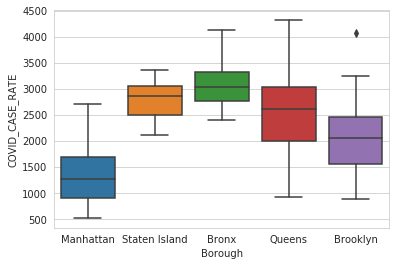

In [38]:
import seaborn as sns
sns.set_style("whitegrid") 
  
sns.boxplot(x = 'Borough', y = 'COVID_CASE_RATE', data = dft) 

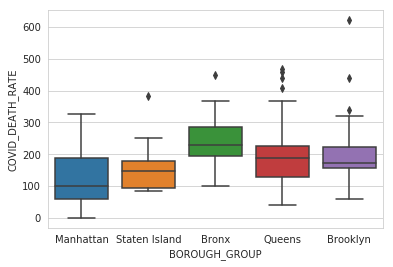

In [40]:
import seaborn as sns
sns.set_style("whitegrid") 
  
sns.boxplot(x = 'BOROUGH_GROUP', y = 'COVID_DEATH_RATE', data = dfcovid) 

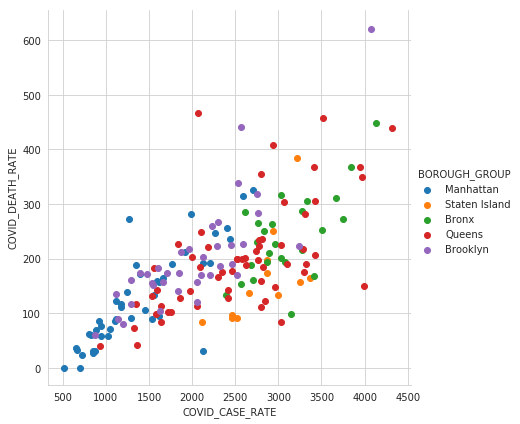

In [15]:
import matplotlib.pyplot as plt 
# style used as a theme of graph  
# for example if we want black  
# graph with grid then write "blackgrid" 
sns.set_style("whitegrid") 
  
# sepal_length, petal_length are iris 
# feature data height used to define 
# Height of graph whereas hue store the 
# class of iris dataset. 
sns.FacetGrid(dfcovid, hue ="BOROUGH_GROUP",  
              height = 6).map(plt.scatter,  
                              'COVID_CASE_RATE',  
                              'COVID_DEATH_RATE').add_legend() 

Extend the data set with location data

In [28]:

geolocator = Nominatim(user_agent="ny_explorer")

# define the dataframe columns
column_names = ['Borough', 'Neighborhood','COVID_CASE_COUNT', 'COVID_CASE_RATE', 'POP_DENOMINATOR', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for index, row in dfcovid_grouped.iterrows():
    borough = row['Borough'] 
    neighborhood_name = row['Neighborhood']
    COVID_CASE_COUNT = row['COVID_CASE_COUNT']
    COVID_CASE_RATE = row['COVID_CASE_RATE']
    POP_DENOMINATOR = row['POP_DENOMINATOR']
    #Search only by neighborhood name and hope for a good luck
    #print (neighborhood_name.split("-")[0])
    try:
        location = geolocator.geocode('{} , New York'.format(neighborhood_name))
        if location is None:
            location = geolocator.geocode('{} , New York'.format(neighborhood_name.split("/")[0]))
        if location is None:
            location = geolocator.geocode('{} , New York'.format(neighborhood_name.split(",")[0]))
        if location is None:
            location = geolocator.geocode('{} , New York'.format(neighborhood_name.split("(")[0]))
        if location is None:
            location = geolocator.geocode('{}'.format(neighborhood_name.split("/")[0]))

        if location is None:
            print('Could not find location for ', neighborhood_name)
        else:    
            latitude = location.latitude
            longitude = location.longitude

            neighborhoods = neighborhoods.append({'Borough': borough,
                                                  'Neighborhood': neighborhood_name,
                                                  'COVID_CASE_COUNT': COVID_CASE_COUNT,
                                                  'COVID_CASE_RATE': COVID_CASE_RATE,
                                                  'POP_DENOMINATOR': POP_DENOMINATOR,
                                                  'Latitude': latitude,
                                                  'Longitude': longitude}, ignore_index=True)
    except:
        print("Unexpected error:", sys.exc_info()[0])

Join both data sets together

In [29]:
neighborhoods.shape

(162, 7)

In [33]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


Get restaurants, clubs, Arts & Entertainment as well as Medical centers

Iterate through categories,assign master categories instead of the real ones

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    categories=[['4d4b7104d754a06370d81259', 'Art'],['4d4b7105d754a06374d81259', 'Food'],['4bf58dd8d48988d104941735', 'Medical']]
    venues_list=[]
    for category, categoryname in categories:
        for name, lat, lng in zip(names, latitudes, longitudes):

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT,
                category)

            # make the GET request
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']

                # return only relevant information for each nearby venue
                venues_list.append([(
                    name, 
                    lat, 
                    lng, 
                    v['venue']['name'], 
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],  
                    categoryname) for v in results])
            except:
                print("Unexpected error:", sys.exc_info()[0])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [42]:
# Now get the venues
import sys
newyork_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyError'> occurred.
Oops! <class 'KeyErr

In [43]:
print(newyork_venues.shape)
newyork_venues.groupby('Neighborhood').count()
print('There are {} uniques categories.'.format(len(newyork_venues['Venue Category'].unique())))

(5973, 7)
There are 3 uniques categories.


In [44]:
# one hot encoding
nyc_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_onehot['Neighborhood'] = newyork_venues['Neighborhood'] 
nyc_onehot['Neighborhood'] = newyork_venues['Neighborhood'] 
nyc_onehot['Neighborhood'] = newyork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

#group by 
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()

nyc_grouped.head()

Neighborhood       Art      Food  \
0                              Airport/East Elmhurst  0.172414  0.827586   
1  Allerton/Baychester/Pelham Gardens/Williamsbridge  0.117647  0.882353   
2     Allerton/Norwood/Pelham Parkway/Williamsbridge  0.093023  0.697674   
3  Alphabet City/East Village/Stuyvesant Town-Coo...  0.352941  0.352941   
4                                 Annadale/Rossville  0.050000  0.750000   

    Medical  
0  0.000000  
1  0.000000  
2  0.209302  
3  0.294118  
4  0.200000

In [45]:
df_concat = pd.concat([neighborhoods, nyc_grouped], axis=1)
df_concat.head()

Borough                                       Neighborhood  \
0     Queens                              Airport/East Elmhurst   
1     Queens  Airport/South Jamaica/Springfield Gardens/St. ...   
2      Bronx  Allerton/Baychester/Pelham Gardens/Williamsbridge   
3      Bronx     Allerton/Norwood/Pelham Parkway/Williamsbridge   
4  Manhattan  Alphabet City/East Village/Stuyvesant Town-Coo...   

  COVID_CASE_COUNT  COVID_CASE_RATE  POP_DENOMINATOR   Latitude  Longitude  \
0             1573         8.451972         36462.23  40.775714 -73.873364   
1             2044        22.314700         67536.11  42.000352 -75.759452   
2             2955        17.304332         71508.25  40.865430 -73.867365   
3             3303        30.752159        100784.05  40.865430 -73.867365   
4              687        50.237720         58747.99  40.725102 -73.979583   

                                        Neighborhood       Art      Food  \
0                              Airport/East Elmhurst  0.172414  0.827586   
1  Allerton/Baychester/Pelham Gardens/Williamsbridge  0.117647  0.882353   
2     Allerton/Norwood/Pelham Parkway/Williamsbridge  0.093023  0.697674   
3  Alphabet City/East Village/Stuyvesant Town-Coo...  0.352941  0.352941   
4                                 Annadale/Rossville  0.050000  0.750000   

    Medical  
0  0.000000  
1  0.000000  
2  0.209302  
3  0.294118  
4  0.200000

<h1>Create a model</h1>
<h2>We will use linear regression</h2>

In [46]:
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
%matplotlib inline

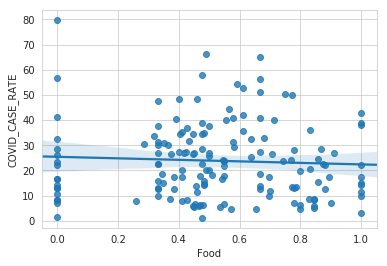

In [58]:
sns.regplot(x='Food', y= 'COVID_CASE_RATE', data= df_concat)


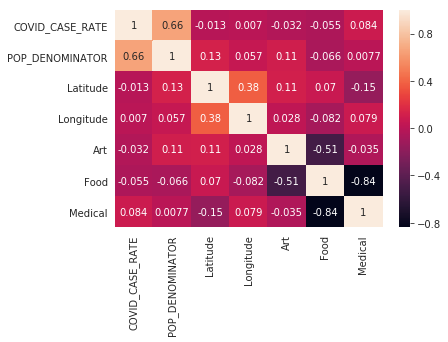

In [60]:

corrMatrix = df_concat.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

BUild a linear regression and check the result

In [70]:
from sklearn import metrics
dfmodel = df_concat.dropna()
features =["Art", "Food","Medical"]     

X = dfmodel[features]
Y = dfmodel['COVID_CASE_RATE']
lm = LinearRegression()
lm.fit(X,Y)
print (lm)
lm.score(X, Y)
yhat = lm.predict(X)
print('Mean Absolute Error:', metrics.mean_absolute_error(Y, yhat))  
print('Mean Squared Error:', metrics.mean_squared_error(Y, yhat))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y, yhat)))
print('R2 score:', metrics.r2_score(Y, yhat))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Mean Absolute Error: 11.785929590247573
Mean Squared Error: 218.7551994831311
Root Mean Squared Error: 14.790375231316178
R2 score: 0.007980795135463903


As expected the score is very low

Now let's try few more models, increasing polynomial order and see if there is any relation

In [53]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=1)

In [68]:
from sklearn.preprocessing import PolynomialFeatures
pr = PolynomialFeatures(degree=2)
x_train_pr = pr.fit_transform(x_train)
x_test_pr = pr.fit_transform(x_test)    

RigeModel=Ridge(alpha=0.1)
RigeModel.fit(x_train_pr, y_train)
RigeModel.score(x_test_pr, y_test)


0.03502016273397435

<h3>Conclusion is that it doesn't matter how many restaurants, night clubs or medical care centers are around for the COVID infectio rate</h3>